In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize



# Basics Gaussian Processes for Regression & Classification Tasks

GP implementation from scratch

We define our model for the function $f:\mathbb{R}^n \rightarrow \mathbb{R}$ with $f \sim GP(m(\cdot), k(\cdot, \cdot))$.

As GPs let us incooperate prior assumbtions into our model,
we have to chose a `mean function` and a `covariance functioon`.

- `mean-function`: Set a mean value for areas without any additional information.
- `cov-function`:  Defines underlying relationship/correlation between observations in relation to their distance.

*For simplicity we set our mean function to:* $mean(x)=0$

### Covariance function: RBF (Radial Basis Function)


$$
k(xi
, xj ) = η * exp(−
\frac{1}{l^2} ||xi − xj ||^2
)
$$



GPs are called non-parametric models.\
Actually we have free parameters based on the covariance function we choose.\
`RBF` has two: $l, η$ \
\
$l$ (`lengthscale`) - Sets strength of correlation between points based on their distance.\
$η$ (`variance`) - Uncertainty in regions without information.

In [5]:
def rbf(Xa, Xb, l=1.0, sigma_f=1.0):
    
    rbf = sigma_f**2 * np.exp(-0.5/(l**2) * ((Xa[:, np.newaxis] - Xb.T)**2))
    rbf_matrix = rbf.reshape(Xa.size, Xb.size)
    return rbf_matrix


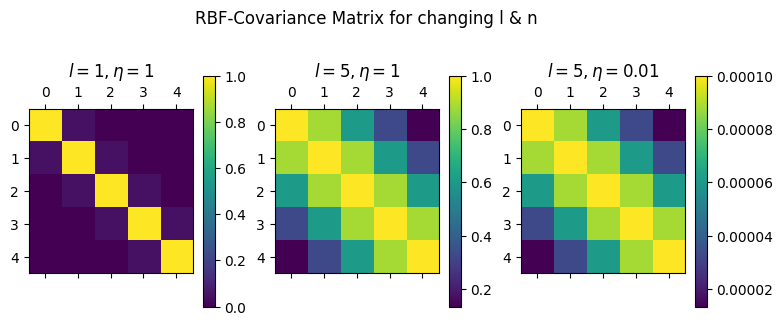

In [6]:
x = np.linspace(-5, 5, 5) # Evenly spaced x values

fig, ax = plt.subplots(ncols=3, figsize=(9,3))
fig.suptitle("RBF-Covariance Matrix for changing l & n", y=1.1)

cx = ax[0].matshow(rbf(x,x,sigma_f=(sig:=1), l=(l:=1)))
fig.colorbar(cx)
ax[0].set_title(f"$l={l}, η={sig}$")

cx = ax[1].matshow(rbf(x,x,sigma_f=(sig:=1), l=(l:=5)))
fig.colorbar(cx)
ax[1].set_title(f"$l={l}, η={sig}$")

cx = ax[2].matshow(rbf(x,x,sigma_f=(sig:=0.01), l=(l:=5)))
fig.colorbar(cx)
ax[2].set_title(f"$l={l}, η={sig}$")

# fig.tight_layout()
plt.show()
plt.close()

We notice two distinct changes when altering l or n.
- Higher l corresponds to a higher covariance between distant input points.
- Variance contributes to the overall variance of the covariance matrix.

## GP Prior

We are already able to sample from our GP-Prior.\
Lets visualize what it represents.

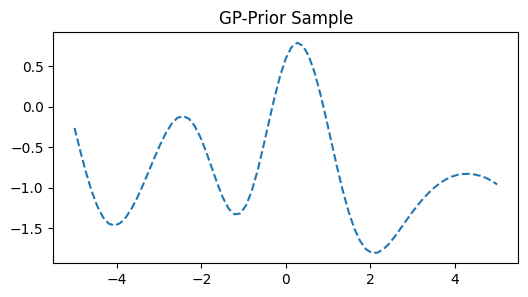

In [10]:
n_samples = 75  # Number of points in each function
n_draws = 1  # Number of functions to sample

x = np.linspace(-5, 5, n_samples) # Evenly spaced x values


cov_matrix = rbf(x,x,sigma_f=1, l=1)

# Calculate y value
y = np.random.multivariate_normal(
    mean=np.zeros(n_samples),
    cov=cov_matrix, 
    size=n_draws
)

plt.figure(figsize=(6, 3))
for i in range(n_draws):
    plt.plot(x, y[i], linestyle='--',markersize=5)

plt.title(f"GP-Prior Sample")
plt.show()
plt.close()

**Lets break down what we did:**

1. Create evenly spaced input vector x = [-5, 5].
2. Calculate the covariance matrix for x via RBF.
3. Draw random samples from the multivariate normal distribution defined by
   - `mean` (Zero mean assumbtion)
   - `covariance-matrix`
4. Plot y against corresponding x values.

> Each sample from our multivariate distribution represents a function.\
> If we set x to cover a infitily small area the function becomes smooth.\
> We can model every non-linear function.

## GP Regression

We use the GP Prior and some observation to make a nonlinear regression.

Given the true function $f$ of some relationship. We make some obervations $[X, Y]$.

#### True Function & Observations

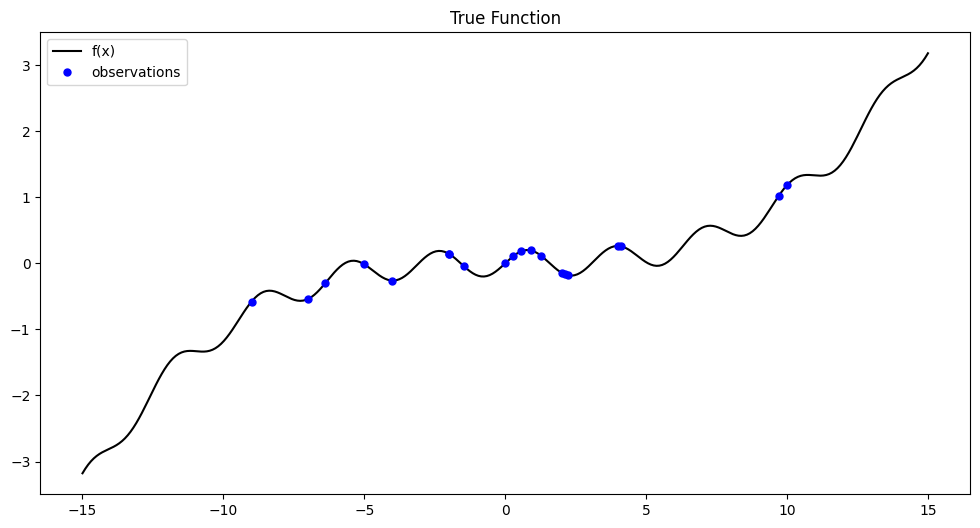

In [27]:
# Define true function
f = lambda a: 0.001*a**3 + 0.2*np.sin(2*a)

x_lin = np.linspace(-15, 15, 300)
f_true = f(x_lin)

# Random observations
np.random.seed(101)
n_observations = 10
X = np.random.randint(-13, 13, size=n_observations)
X = list(X) + list(np.random.normal(0,4,10))
X = np.array(X)
X.sort()
Y = f(X)


# For later convinience
def plot_true_function():
    # Plot true function
    plt.figure(figsize=(12, 6))
    plt.plot(x_lin, f_true, c="k", linestyle="-", label="f(x)")
    plt.title("True Function")
    
    # Plot observations
    plt.plot(X, Y, c="b", linestyle="", marker="o", markersize=5, label="observations")
    plt.legend()


plot_true_function()
plt.show()
plt.close()

### Hyperparameter Optimization

> Finding the best hyperparameter combination for our prior?

We already made some observations. These can be used to optimize our rbf-kernels hyperparameters.

This can be done via the marginal likelihood, which is obtained by

$$ p(\boldsymbol{y}|X) = \int p(\boldsymbol{y}|\boldsymbol{f},X) p(\boldsymbol{f}|X) d \boldsymbol{f} $$

which yields

$$ \log p(\boldsymbol{y}|X) = - \frac{1}{2} \boldsymbol{y}^T (K + \sigma^2 I)^{-1}\boldsymbol{y} - \frac{1}{2}\log |K + \sigma^2 I| - \frac{n}{2} \log 2\pi $$

By maximizing the marginal likelihood with respect to the hyperparameters, we get the best combination for $l$ and $n$.

*For a detailed describtion of all steps I refer to [Rasmussen - Gaussian Processes](https://gaussianprocess.org/gpml/chapters/RW.pdf). But bring some time. :)*

In [9]:

def log_marginal_likelihood(x, y, length_scale, sig_noise):
    """
    Calculates the log marginal likelihood of the prior given the observations.
    """
    
    n_samples = x.shape[0]
    jitter = 1e-4
    K = rbf(x,x,length_scale,sig_noise) + jitter * np.eye(n_samples) # Added jitter
    K_inv = np.linalg.inv(K)
    log_marginal_like = -0.5 * y.T @ K_inv @ y - 0.5 * np.log(np.linalg.det(K)) - 0.5 * n_samples * np.log(2 * np.pi)
    return log_marginal_like


# Optimization of hyperparameters

def opt_goal(param):
    l = param[0]
    sig = param[1]
    log_marg = log_marginal_likelihood(x, Y, l, sig)
    return -log_marg

h_param_start = np.array([1, 1])

res = scipy.optimize.minimize(opt_goal, h_param_start, bounds=((0.01, None), (1e-8, None)), method='L-BFGS-B',
                              options={'gtol': 1e-12, 'disp': False})

l_opt = res.x[0]
sig_opt = res.x[1]
print(f"Optimized Lenghtscale & Variance of rbf-kernel: {res.x}")

Optimized Lenghtscale & Variance of rbf-kernel: [1.16812502 0.285609  ]


### Posterior Distribution
> Incooperating observations into our existing prior and approximate the "true" function?

The posterior formula after combining `prior` & `likelihood`(of the observations)

...Here could be brief explanation of bayes formula and the relationship between posteroir, prior and likelihood...

$p(f∗|X∗,X,f)=N(f∗|μ∗,Σ∗$)$

$μ∗=K^T_∗K^{−1}f$

$Σ∗=K_{∗∗}−K^T_*K^{−1}K_∗$

Where:\
$f$: target values of observations.\
$K$: cov-Matrix of observations $X$\
$K_*$: cov-Matrix between obs. $X$, points to predict $X_*$\
$K_**$: cov-Matrix of points to predict $X_*$

The following formula is obtained from \

*For a detailed describtion of all steps I refer to [Rasmussen - Gaussian Processes](https://gaussianprocess.org/gpml/chapters/RW.pdf). But bring some time. :)*

In [16]:
# Helper functions

def mean_func(x):
    return np.zeros(x.size)

def calc_kernel_matrix(x_obs, x_pred, l=1., sig=1.):
    """
    Calculates kernel matrix for K, K_s, K_ss
    """
     
    x_pred = np.expand_dims(x_pred, 1)
    x_obs = np.expand_dims(x_obs, 1)
    K = rbf(x_obs, x_obs, l, sig)
    K_s = rbf(x_obs, x_pred, l, sig)
    K_ss = rbf(x_pred, x_pred, l, sig)
    
    return K, K_s, K_ss

def calc_predictive_posterior_distribution(K, K_s, K_ss, y_obs):
    
    K_inv = np.linalg.inv(K + np.eye(K.shape[0]) * 1e-4)
    K_ss_posterior = K_ss - K_s.T @ K_inv @ K_s
    mu_posterior = K_s.T @ K_inv @ y_obs
    
    return K_ss_posterior, mu_posterior
    
def sample_posterior(K_posterior, mu_posterior, n_draws):
    
    multivariate_sample = np.random.multivariate_normal(
            mean=mu_posterior,
            cov=K_posterior, 
            size=n_draws
        )
    
    return multivariate_sample


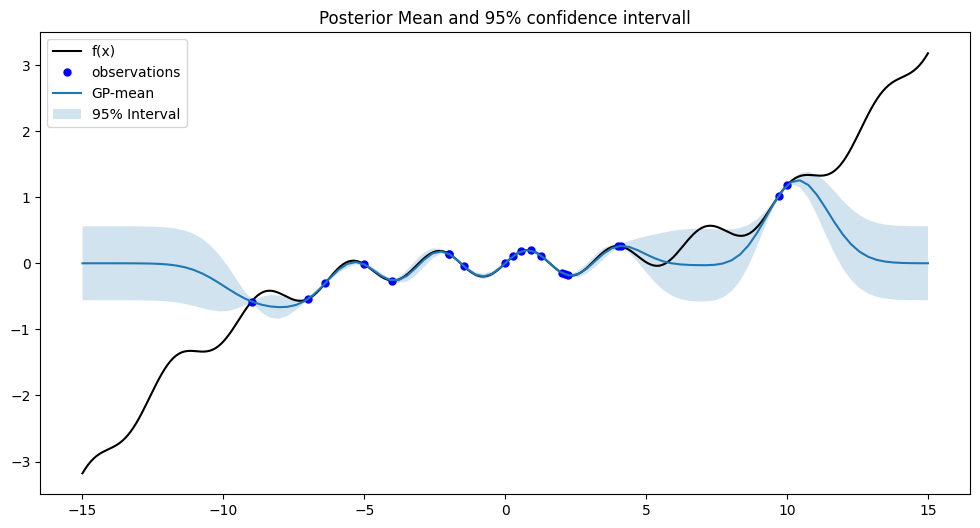

In [28]:
# Sample points
X_pred = np.linspace(-15, 15, 100)

K, K_s, K_ss = calc_kernel_matrix(X, X_pred, l_opt, sig_opt)

K_ss_posterior, mu_posterior = calc_predictive_posterior_distribution(K, K_s, K_ss, Y)

interval = 1.96 * np.sqrt(np.diag(K_ss_posterior))


plot_true_function()

plt.plot(X_pred, mu_posterior, label="GP-mean")
plt.fill_between(X_pred.flatten(), mu_posterior - interval, mu_posterior + interval, alpha=0.2, label='95% Interval')

plt.title("Posterior Mean and 95% confidence intervall")
plt.legend()

plt.show()
plt.close()

As we can see, a low number of observation is enough to approximate the function.